In [88]:
import os
import argparse
import logging
import functools
import itertools
import tqdm
import torchvision
from torch.utils.data import DataLoader
import zarr
import dask
import dask.array as da
import zarrdataset
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import glob
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image, ImageFilter
from skimage import filters
from skimage.color import rgb2gray
from skimage.morphology import area_closing, area_opening,remove_small_holes
from skimage.measure import label, regionprops, regionprops_table
import warnings
#warnings.filterwarnings("ignore")

def timeit(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('func:%r took: %2.4f sec)' %\
              (f.__name__, te-ts))
        return result
    return timed

def generate_mask_from_img(data):
    img = Image.fromarray(data, 'RGB').filter(ImageFilter.GaussianBlur(radius = 10))
    thre = filters.threshold_otsu(np.array(img))
    mask = np.array(img)[:,:,0] <= thre
    opened = remove_small_holes(mask,area_threshold= 1e5)
    mask, bbox = remove_holes_in_mask(opened)
    return mask,bbox

def remove_holes_in_mask(mask):
    opened = remove_small_holes(mask,area_threshold= 1e5)
    label_im = label(opened)
    regions = regionprops(label_im)
    for num, x in enumerate(regions):
        if (regions[num].axis_minor_length>500):
            break 
    bbox=regions[num].bbox
    masks = regions[num].convex_image
    opened1 = opened[bbox[0]:bbox[2], bbox[1]:bbox[3]] * masks
    #result = padding_2d(opened, opened1, bbox)
    return opened1, bbox
    
# def padding_2d(d, d1,box):
#     result = np.zeros(d.shape)
#     result[box[0]:box[2], box[1]:box[3]] = d1
#     return result

def generate_ordinal_mask(data, mask, age, ages = [6,12,18]):
    x, y = mask.shape
    if age == ages[0]:
        ordinal_mask = np.dstack([mask, np.zeros((x, y)), np.zeros((x, y))])
    elif age == ages[1]:
        ordinal_mask = np.dstack([mask, mask, np.zeros((x, y))])
    elif age == ages[2]:
        ordinal_mask = np.dstack([mask, mask, mask])
    else: 
        print("The age is not in the age list: ", age, ages)
        sys.exit()
#     print("mask dim ", ordinal_mask.shape)
#     print("data dim ",data.shape)
    return ordinal_mask 

def get_label(age, ages = [6,12,18]):
    if age == ages[0]:
        return np.array([1,0,0])
    elif age == ages[1]:
        return np.array([1,1,0])
    elif age == ages[2]:
        return np.array([1,1,1])
    else:
        print("The age is not in the age list: ", age, ages)
        sys.exit() 

def get_age(files_select, sample_id):
    return files_select[files_select.filename == sample_id].age.values[0]

In [2]:
## read data from zarr[0][4]
def get_data(file):
    df = zarr.open(file)
    filename = os.path.basename(file)
    #print(file)
    df[0][4].info
    tile = df[0][4]
    _, _, s1, s2, s3 = tile.shape
    #print(s1, s2, s3),
    tile = tile[0,0,0:s1,0:s2,0:s3]
    #print(tile.shape)
    data = np.transpose(tile, (1, 2, 0)) 
    x_length = np.where(data[1,:,1] == 255)[0]
    if len(x_length) > 0:
        ### imgs from jax has 3 tissues images, choose the first one 
        x_length = x_length[np.argmax(np.array(x_length)>1800)] 
    else:
        x_length = data.shape[1]
    print(x_length)
    x_start = 0
    data = data[:,x_start:x_start+x_length,:]
    return data

def plot_data_mask(data,mask, filename=""):
    plt.figure(figsize=(2, 2),dpi=80)
    f, ax = plt.subplots(1,2)
    ax[0].imshow(data)
    ax[0].set_title(filename)
    ax[1].imshow(mask,cmap="gray")
    ax[1].set_title(mask.shape)
    
def plot_ordinal_mask(ordinal_mask, age, filename=""):
    plt.figure(figsize=(2, 2),dpi=80)
    f, ax = plt.subplots(1,3)
    ax[0].imshow(ordinal_mask[:,:,0],cmap="gray")
    ax[1].imshow(ordinal_mask[:,:,1],cmap="gray")
    ax[2].imshow(ordinal_mask[:,:,2],cmap="gray")
    f.suptitle(filename+ "  Age:"+ str(age))
    ax[0].set_title("Channel 1")
    ax[1].set_title("Channel 2")
    ax[2].set_title("Channel 3")
    plt.tight_layout()
    f.subplots_adjust(top=1.2)
    
@timeit
def preprocess(files, save_path, plot_fig = False):
    print(len(files))
    for i in range(len(files)):
        file = files[i]
        filename = os.path.basename(file)      
        data =  get_data(file)
        mask,bbox =  generate_mask_from_img(data)
        data = data[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        age = get_age(files_select, filename)
        print(str(i) + ": " + file + " Age: "+str(age))
        ordinal_mask = generate_ordinal_mask(data, mask, age)
        if plot_fig:
            plot_data_mask(data, mask, filename)  
        data[:,:,0] = data[:,:,0]*mask
        data[:,:,1] = data[:,:,1]*mask
        data[:,:,2] = data[:,:,2]*mask      
        store = zarr.DirectoryStore(save_path + filename)
        root = zarr.group(store=store, overwrite=True)
        data1 = root.create_group('data')
        mask1 = root.create_group('mask')
        ordinal_mask1 = root.create_group('ordinal_mask')
        root['data'] = data
        root['mask']  = mask
        root['ordinal_mask']  = ordinal_mask

# Get files, remove outliers 

In [3]:
filepath_jax = "/projects/korstanje-lab/DO-DNN/DO_Batches_zarrs/"
filepath_germany = "/projects/korstanje-lab/DO-DNN/DO_Batches_Boor_zarrs/"
files_jax= glob.glob(filepath_jax+ "*.zarr")
files_germany= glob.glob(filepath_germany+ "*.zarr")
save_filepath = "/projects/korstanje-lab/chenm/DO-DNN/data_zarrs/"
meta = pd.read_csv("/projects/korstanje-lab/chenm/DO-DNN/meta_data/meta.csv", sep=",")
outliers = pd.read_csv("/projects/korstanje-lab/chenm/DO-DNN/meta_data/CombinedSiteOutliers3STdev.csv", sep=",")
outliers_ids = outliers["X.dataset.filename"].str.split('[_\|.]').str[1]
#print(outliers.shape)
files_all = pd.DataFrame(files_jax + files_germany, columns=["filepath"])

files_all["filename"] = files_all.filepath.str.split('/').str[-1]
files_all["folder"] = files_all.filepath.str.split('/').str[-2]
files_all["id"] = files_all.filename.str.split('[_\|.]').str[2]
files_all["location"] = "jax"
files_all.loc[files_all.folder == "DO_Batches_Boor_zarrs","location"] = "germany"
files_all["outlier"] = False 
files_all.loc[files_all.id.isin(outliers_ids), "outlier"] =True
files_all = files_all.merge(meta[["filename", "age"]], left_on ="filename", right_on="filename")
files_select = files_all[~files_all.outlier]
print("# of removed outlier:", str(sum(files_all.outlier)))
print("# of selected samples:", str(len(files_select)))
print("# of selected samples from Jax:", str(sum(files_select.location == "jax")))
print("# of selected samples from Germany:", str(sum(files_select.location == "germany")))
print(files_select.groupby(["age"]).count())

# of removed outlier: 16
# of selected samples: 449
# of selected samples from Jax: 371
# of selected samples from Germany: 78
     filepath  filename  folder   id  location  outlier
age                                                    
6         129       129     129  129       129      129
12        185       185     185  185       185      185
18        135       135     135  135       135      135


# Generate and save a zarr file for each sample which contains tissue image, mask and ordinal mask

In [4]:
files = files_select.filepath.values
# the zarrs are saved at: /projects/korstanje-lab/chenm/DO-DNN/data_zarrs/
#preprocess(files, save_filepath)

# Check image, mask and ordinal mask generated from preprocess function 

<Figure size 160x160 with 0 Axes>

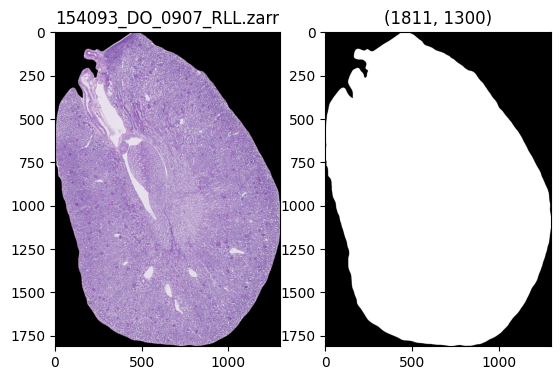

In [95]:
to_check = '154093_DO_0907_RLL.zarr'
df = zarr.open(save_filepath+to_check)
data = df["data"]
mask = df["mask"]
ordinal_mask = df["ordinal_mask"]
plot_data_mask(df["data"], df["mask"], to_check)
age = get_age(files_select, to_check)
#plot_ordinal_mask(ordinal_mask, age, to_check)
to_check2 = '150628_DO_1084.zarr'
df = zarr.open(save_filepath+to_check)
data = df["data"]
mask = df["mask"]

# Set up logger

In [96]:
log_dir = "/fastscratch/chenm/"
# Check whether the log_dir path exists or not
isExist = os.path.exists(log_dir)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(log_dir)


log_identifier = "ViT_H_14"
print_log = True
logger = logging.getLogger('train_log')
logger.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

fh = logging.FileHandler(os.path.join(log_dir, "train_vit_classifier%s.log" % log_identifier), mode='w')
fh.setFormatter(formatter)
logger.addHandler(fh)

if print_log:
    console = logging.StreamHandler()
    console.setFormatter(formatter)
    logger.addHandler(console)
    console.setLevel(logging.DEBUG)

In [100]:
num_epochs = 20  # 
batch_size = 20   #  limmit by the memory of the GPU 
patch_size = 518 # size of training images
num_workers = 8

bias = True # 

rng_seed = 0

des_path = "/projects/korstanje-lab/chenm/DO-DNN/results/"

    
torch.manual_seed(rng_seed)
np.random.seed(rng_seed + 1)
random.seed(rng_seed+1, 2)

def get_training_and_testing_data(files, n_train, n_val, rng_seed):
    files_train = files.sample(n=n_train,random_state=rng_seed)
    files_left = files[~files.index.isin(files_train.index)]
    files_val = files_left.sample(n=n_val,random_state=rng_seed)
    return files_train, files_val

files_train, files_val =  get_training_and_testing_data(files_select,10,10, rng_seed)
trn_files  = files_train.filename.values
val_files = files_val.filename.values

logger.debug(f"Training files\n{trn_files}")
logger.debug(f"Validation files\n{val_files}") 
print(trn_files)

['154060_DO_0767_RLL.zarr' '150895_DO_1210.zarr'
 '334125_DO_0735_RR_PAS.svs [0].zarr' '151072_DO_1299.zarr'
 '150607_DO_1070.zarr' '154282_DO_1013_L.zarr' '150913_DO_1217.zarr'
 '153994_DO_0736_LL.zarr' '154246_DO_0993_L.zarr'
 '154048_DO_0760_LLL.zarr']


# Load the pretrained Vision Transoformer (ViT)

In [89]:
logger = logging.getLogger('train_log')

logger.info("Loading vision transformer from torchvision.models.vit_b_16")

vit_checkpoint = torchvision.models.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1

model = torchvision.models.vit_h_14(weights=vit_checkpoint, progress=False)

# Freeze the model parameters to perform fine tuning only on the last layer (classifier)
for par in model.parameters():
    par.requires_grad = False
    
num_class = 3 # num of age groups 

layers = []
layers.append(nn.Linear(in_features=1280, out_features=num_class, bias=bias))
#layers.append(nn.Sigmoid())
#layers.append(nn.BCELoss())

net = nn.Sequential(*layers)

model.heads = nn.Sequential(*layers)

model.cuda()
net.cuda()

logger.debug("Model\n%s" % str(model))

2023-08-04 15:22:51,076 - INFO - Loading vision transformer from torchvision.models.vit_b_16


In [82]:
# Optimize only the classifier head of the model, since everything else is frozen
optimizer = optim.Adam(model.heads.parameters(), lr=1e-4)

# For one-hot encoding use the BCE with logits loss function
criterion = nn.BCEWithLogitsLoss()

logger.info("Optimizer: Adam, lr=1e-4")
logger.info("Criterion: BCE with logits")

2023-08-04 15:18:52,770 - INFO - Optimizer: Adam, lr=1e-4
2023-08-04 15:18:52,772 - INFO - Criterion: BCE with logits


# Prepare inputs 

In [90]:
# This is an auxiliary class that extracts patches from the zarr files without having to save them separately
import tqdm

patch_size=518
patch_sampler = zarrdataset.GridPatchSampler(patch_size=patch_size)
transforms_pipeline = [
    zarrdataset.ZarrToArray(dtype=np.uint8),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.transforms.Resize((patch_size, patch_size), antialias = True)
]

input_transforms = torchvision.transforms.Compose(transforms_pipeline) 

def generate_xy(filename):
    age = get_age(files_select, filename)
    fn = save_filepath + filename
    df = zarr.open(fn, mode = "r")
    label = get_label(age)
    print(filename, age, label)
    return (input_transforms(df["data"]), label)


def get_DataLoader(ds):
    dl = DataLoader(
    ds,
    batch_size=1,
    num_workers=8,
    pin_memory=True,
    shuffle = True)
    return dl


trn_ds = []
for filename in tqdm.tqdm(trn_files):
    trn_ds.append(generate_xy(filename))
    trn_dl = get_DataLoader(trn_ds)
    
val_ds = []
for filename in tqdm.tqdm(val_files):
    val_ds.append(generate_xy(filename))
    val_dl = get_DataLoader(val_ds)


  0%|                                                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

154060_DO_0767_RLL.zarr 18 [1 1 1]


 10%|██████████████████                                                                                                                                                                   | 1/10 [00:00<00:02,  3.96it/s]

150895_DO_1210.zarr 12 [1 1 0]


 50%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 5/10 [00:00<00:00, 10.32it/s]

334125_DO_0735_RR_PAS.svs [0].zarr 12 [1 1 0]
151072_DO_1299.zarr 6 [1 0 0]
150607_DO_1070.zarr 12 [1 1 0]
154282_DO_1013_L.zarr 12 [1 1 0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.23it/s]


150913_DO_1217.zarr 6 [1 0 0]
153994_DO_0736_LL.zarr 12 [1 1 0]
154246_DO_0993_L.zarr 12 [1 1 0]
154048_DO_0760_LLL.zarr 12 [1 1 0]


  0%|                                                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

153844_DO_0666_LL.zarr 12 [1 1 0]


 10%|██████████████████                                                                                                                                                                   | 1/10 [00:00<00:05,  1.76it/s]

150940_DO_1230.zarr 6 [1 0 0]


 20%|████████████████████████████████████▏                                                                                                                                                | 2/10 [00:00<00:03,  2.18it/s]

154165_DO_0951_N.zarr 12 [1 1 0]


 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 3/10 [00:01<00:03,  1.92it/s]

153916_DO_0698_RRL.zarr 12 [1 1 0]


 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                            | 4/10 [00:01<00:02,  2.05it/s]

150925_DO_1221.zarr 6 [1 0 0]


 50%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 5/10 [00:02<00:02,  2.15it/s]

154114_DO_0920_LLL.zarr 12 [1 1 0]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 6/10 [00:02<00:01,  2.16it/s]

150853_DO_1194.zarr 6 [1 0 0]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 7/10 [00:03<00:01,  2.16it/s]

150877_DO_1204.zarr 6 [1 0 0]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 8/10 [00:03<00:01,  1.92it/s]

150580_DO_1056.zarr 18 [1 1 1]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 9/10 [00:04<00:00,  1.79it/s]

150598_DO_1066.zarr 12 [1 1 0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.89it/s]


In [97]:
for x,y in trn_ds:
    print(x.shape, y.shape)

torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)
torch.Size([3, 518, 518]) (3,)


In [98]:
def train_step(trn_dl, model, criterion, optimizer):
    model.train()
    total_loss = 0
    total_samples = 0

    for i, (x, t) in enumerate(trn_dl):
        optimizer.zero_grad()
        y_hat = model(x.cuda())
        loss = criterion(y_hat, t.to(y_hat.device).float())
        loss.backward()

        optimizer.step()
        
        total_loss += loss.item()
        total_samples += x.size(0)

        if i % 10 == 0:
            logger.debug(f"Training step {i}, avg. training loss={total_loss / total_samples}")

    # Return the average training loss of ths epoch
    return total_loss / total_samples

In [99]:
best_val_loss = float('inf')
last_checkpoint_fn = os.path.join(log_dir, "last_vit_classifier%s.pth" % log_identifier)
best_checkpoint_fn = os.path.join(log_dir, "best_vit_classifier%s.pth" % log_identifier)



def validation_step(val_dl, model, criterion):
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for i, (x, t) in enumerate(val_dl):
            y_hat = model(x.cuda())
            loss = criterion(y_hat, t.to(y_hat.device).float())

            total_loss += loss.item()
            total_samples += x.size(0)
            if i % 10 == 0:
                logger.debug(f"Validation step {i}, avg. validation loss={total_loss / total_samples}")
    # Return the average validation loss of this epoch
    return total_loss / total_samples


trn_loss_list = []
val_loss_list = []

for e in range(num_epochs):
    trn_loss = train_step(trn_dl, model, criterion, optimizer)
    print(trn_loss)
    val_loss = validation_step(val_dl, model, criterion)
    print(val_loss)
    trn_loss_list.append(trn_loss)
    val_loss_list.append(val_loss)

    last_checkpoint = dict(
        model=model.state_dict(),
        epoch=e,
        trn_loss=trn_loss_list,
        val_loss=val_loss_list,
        best_val_loss=best_val_loss)
    torch.save(last_checkpoint, last_checkpoint_fn)

    if best_val_loss > val_loss:
        best_val_loss = val_loss
        best_checkpoint = dict(
            model=model.state_dict(),
            epoch=e,
            trn_loss=trn_loss_list,
            val_loss=val_loss_list,
            best_val_loss=best_val_loss)
        torch.save(best_checkpoint, best_checkpoint_fn)
    logger.info(f"Epoch {e + 1}, avg. training loss={trn_loss}, avg. validation loss={val_loss}")

0.6818173348903656
0.6646040558815003


2023-08-04 15:28:52,270 - INFO - Epoch 1, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:28:52,270 - INFO - Epoch 1, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:29:09,964 - INFO - Epoch 2, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:29:09,964 - INFO - Epoch 2, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:29:27,054 - INFO - Epoch 3, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:29:27,054 - INFO - Epoch 3, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:29:44,185 - INFO - Epoch 4, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:29:44,185 - INFO - Epoch 4, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:29:59,989 - INFO - Epoch 5, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:29:59,989 - INFO - Epoch 5, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:30:19,172 - INFO - Epoch 6, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:30:19,172 - INFO - Epoch 6, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:30:39,013 - INFO - Epoch 7, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:30:39,013 - INFO - Epoch 7, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:30:56,838 - INFO - Epoch 8, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:30:56,838 - INFO - Epoch 8, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:31:15,358 - INFO - Epoch 9, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:31:15,358 - INFO - Epoch 9, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:31:33,014 - INFO - Epoch 10, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:31:33,014 - INFO - Epoch 10, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:31:50,036 - INFO - Epoch 11, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:31:50,036 - INFO - Epoch 11, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:32:07,564 - INFO - Epoch 12, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:32:07,564 - INFO - Epoch 12, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:32:26,157 - INFO - Epoch 13, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:32:26,157 - INFO - Epoch 13, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:32:46,565 - INFO - Epoch 14, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:32:46,565 - INFO - Epoch 14, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:33:05,895 - INFO - Epoch 15, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:33:05,895 - INFO - Epoch 15, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:33:24,772 - INFO - Epoch 16, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:33:24,772 - INFO - Epoch 16, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:33:42,805 - INFO - Epoch 17, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:33:42,805 - INFO - Epoch 17, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:34:00,187 - INFO - Epoch 18, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:34:00,187 - INFO - Epoch 18, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:34:18,223 - INFO - Epoch 19, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:34:18,223 - INFO - Epoch 19, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003


0.6818173348903656
0.6646040558815003


2023-08-04 15:34:36,011 - INFO - Epoch 20, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
2023-08-04 15:34:36,011 - INFO - Epoch 20, avg. training loss=0.6818173348903656, avg. validation loss=0.6646040558815003
